# Classification

In [1]:
import requests
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import requests

In [2]:
LIMIT = 100

In [3]:
def get_data(topics):
    result,labels = [], []
    for topic in topics:
        json = requests.get('http://192.168.1.34:8000/api/entity/query?wikidataId={}&limit={}'
                            .format(topic['wikidata_id'],LIMIT)).json()
        data = {'label': topic['label']}
        data['data'] = [row['text'] for row in json['result']]
        result.append(data)
        labels.append(topic['label']) if not topic['label'] in labels else None
        
    return result,labels

def get_x_and_y(data):
    x,y = [], []
    for d in data:
        x.extend(d['data'])
        y += [d['label'] for i in range(0,len(d['data']))]
        
    return x,y
        
    

In [5]:
data,labels = get_data([{'label': 'Aircraft', 'wikidata_id':'Q11436'}, 
                        {'label': 'Automobile', 'wikidata_id': 'Q1420'},
                        {'label': 'Video Game', 'wikidata_id': 'Q7889'}])
x,y = get_x_and_y(data)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33, random_state=42)

In [8]:
def predict_category(t, y_train, model):
    pred = model.predict([t])
    return pred

## Multinomial Bayes Classification

In [20]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(x_train, y=y_train)

result_labels = model.predict(x_test)


In [29]:
mat = confusion_matrix(y_test,result_labels)

['Aircraft', 'Automobile', 'Video Game']


<AxesSubplot:>

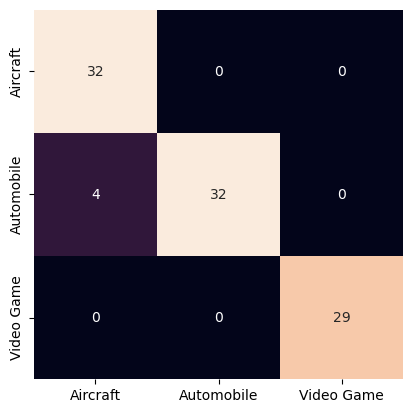

In [30]:


print(labels)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=labels, yticklabels=labels)

In [197]:
result = predict_category(x_test[30],y_train,model)
print('Actual: %s, Prediction: %s' % (y_test[30], result))


Actual: Aircraft, Prediction: ['Aircraft']


/home/cnytync/Dev/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## KNN Classification

In [192]:
from sklearn.neighbors import KNeighborsClassifier
model = make_pipeline(TfidfVectorizer(),KNeighborsClassifier())

model.fit(x_train,y_train)

result_labels = model.predict(x_train)

mat = confusion_matrix(y_train,result_labels)

print(labels)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=labels, yticklabels=labels)

## Topic Modelling

In [12]:
from top2vec import Top2Vec
model = Top2Vec(x_train + x_test)

2022-12-17 11:45:24,747 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2022-12-17 11:45:24,787 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-12-17 11:45:26,194 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2022-12-17 11:45:28,035 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2022-12-17 11:45:28,044 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [13]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [14]:
print(topic_sizes)

[195  97]


In [17]:
topic_words, word_scores, topic_nums = model.get_topics(2)

In [18]:
for word, score, num in zip(topic_words, word_scores, topic_nums):
    print(num)
    print(f"Words: {word}")

0
Words: ['and' 'the' 'in' 'to' 'of' 'games' 'or' 'first' 'game' 'that' 'by' 'at'
 'is' 'released' 'with' 'as' 'its' 'was' 'from' 'developed' 'for' 'it'
 'series' 'video' 'were' 'produced' 'an' 'on' 'designed' 'aircraft'
 'published' 'built']
1
Words: ['series' 'games' 'an' 'was' 'by' 'with' 'and' 'first' 'published' 'in'
 'is' 'from' 'released' 'of' 'to' 'as' 'the' 'it' 'at' 'were' 'designed'
 'for' 'or' 'game' 'aircraft' 'its' 'on' 'built' 'that' 'produced' 'video'
 'developed']


In [32]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=10)